(**Click the icon below to open this notebook in Colab**)
[![Open InColab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/xiangshiyin/machine-learning-for-actuarial-science/blob/main/2025-spring/week03/notebook/demo.ipynb)

In [14]:
%%sh

which python

/Users/xiangshiyin/Documents/Teaching/machine-learning-for-actuarial-science/.venv/bin/python


# Load the MNIST data

We will take the built-in hand-written digits dataset in `scikit-learn` as an example. This is a copy of the test set of the UCI ML hand-written digits datasets https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

Each datapoint is a 8x8 image of a digit.

| Attribute           | Value         |
|---------------------|---------------|
| Classes             | 10            |
| Samples per class   | ~180          |
| Samples total       | 1797          |
| Dimensionality      | 64            |
| Features            | integers 0-16 |


In [15]:
from sklearn import datasets

digits = datasets.load_digits()

In [16]:
data = digits.data
target = digits.target
feature_names = digits.feature_names
target_names = digits.target_names

In [17]:
print(f"The shape of the data is {data.shape}")
print(f"The shape of the target is {target.shape}")
print(f"First 5 feature names are {feature_names[:5]}")
print(f"Target names are {target_names}")

The shape of the data is (1797, 64)
The shape of the target is (1797,)
First 5 feature names are ['pixel_0_0', 'pixel_0_1', 'pixel_0_2', 'pixel_0_3', 'pixel_0_4']
Target names are [0 1 2 3 4 5 6 7 8 9]


In [18]:
target[:5]

array([0, 1, 2, 3, 4])

# Visualize the MNIST digits

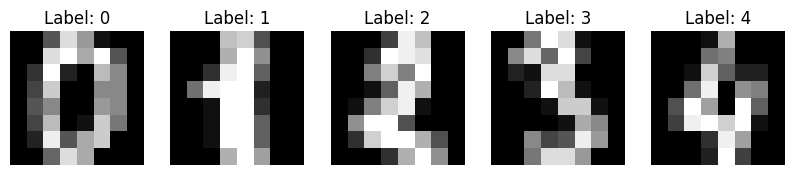

In [19]:
# visualize the first 5 images

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 5, figsize=(10, 5))
for i in range(5):
    ax[i].imshow(data[i].reshape(8, 8), cmap='gray')
    ax[i].set_title(f"Label: {target[i]}")
    ax[i].axis('off')

# The loss function

We use the cross-entropy loss function for this classification problem. 

## Single Data Point
For a single data point, the categorical cross-entropy loss function is defined as:

$$
\begin{aligned}
L = -\sum_{i=1}^{C}y_i log(p_i)
\end{aligned}
$$

Where:
* $C$ is the number of classes
* $y_i$ is the true label (a one-hot encoded vector, where $y_i=1$ for the correct class and $y_i=0$ for the incorrect classes)
* $p_i$ is the predicted probability for class $i$ (output of the softmax function)

## Multiple Data Points

For a batch of N data points, the loss function is defined as the average over the whole batch:

$$
\begin{aligned}
L = -\frac{1}{N}\sum_{j=1}^{N}\sum_{i=1}^{C}y_{ij} log(p_{ij})
\end{aligned}
$$

## Implement the cross-entropy loss function with `numpy`

In [20]:
import numpy as np

# Implement the single-sample version of the loss function
def cross_entropy_loss_single(y_true, y_pred):
    # Clip the predicted values to avoid log(0)
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
    # Calculate the cross-entropy loss for a single sample
    loss = -np.sum(y_true * np.log(y_pred))
    return loss

In [21]:
# Example: test the single-sample loss function
y_true = np.array([0,1,0])
y_pred_1 = np.array([0.,0.99,0.01])
y_pred_2 = np.array([0.2,0.7,0.1])
y_pred_3 = np.array([0.7,0.2,0.1])
y_pred_4 = np.array([0.33,0.33,0.34])
loss_1 = cross_entropy_loss_single(y_true,y_pred_1)
loss_2 = cross_entropy_loss_single(y_true,y_pred_2)
loss_3 = cross_entropy_loss_single(y_true,y_pred_3)
loss_4 = cross_entropy_loss_single(y_true,y_pred_4)
print(f"Loss 1: {loss_1}")
print(f"Loss 2: {loss_2}")
print(f"Loss 3: {loss_3}")
print(f"Loss 4: {loss_4}")

Loss 1: 0.01005033585350145
Loss 2: 0.35667494393873245
Loss 3: 1.6094379124341003
Loss 4: 1.1086626245216111


In [22]:
# Implement the multi-sample version of the loss function
def cross_entropy_loss_multi(y_true, y_pred):
    # Calculate the number of samples in the batch
    num_samples = y_true.shape[0]
    # Calculate the cross-entropy loss for each sample
    losses = -np.sum(y_true * np.log(y_pred), axis=1)
    # Calculate the average loss across all samples
    loss = np.sum(losses) / num_samples
    return loss

In [26]:
# Example: test the multi-sample loss function
## Generate 
y_true = np.array([
    [1,0,0],
    [0,1,0],
    [0,0,1]
])
y_pred = np.random.random(size=(3, 3))
y_pred = y_pred / y_pred.sum(axis=1, keepdims=True)
loss = cross_entropy_loss_multi(y_true, y_pred)
print(y_true)
print(y_pred)
print(y_pred.sum(axis=1)) # validate if the total is 1
print(f"Loss = {loss}")

[[1 0 0]
 [0 1 0]
 [0 0 1]]
[[0.17302208 0.38173056 0.44524735]
 [0.52762306 0.17116262 0.30121432]
 [0.73827282 0.14995137 0.11177581]]
[1. 1. 1.]
Loss = 1.9035791111153009
